# Overview

This analysis explores sentiment changes towards Volkswagen during the period around its emission scandal.
The following steps were taken:

* [1. News filtering](#news_filtering)
    * 1.1 Simple filtering with keywords
    * 1.2 Sanity check of filtering results
    
* [2. Improve the sample](#heuristic_filtering)
    * 2.1 Relation between title mention and relevance
    * 2.2 Heuristic rules for further filtering
    * 2.3 Possible further analysis
    
* [3. Sentiment analysis](#sentiment_analysis)
    * 3.1 Questions to be answered
    * 3.2 Sentiment over time
    * 3.3 What has been said about VW in news?
    * 3.4 Who's been talking about me?
    * 3.5 Possible further analysis
* [4. Limitations](#limitations)


## Ground truth (check points)
* According to Wikipedia, the following points on the timeline are of interest:
    - 3rd Sep EPA threatens to not certify 2016 diesels
    - 18th Sep the Public announcement by EPA of order to recall 2009–2015 cars 
    - 20th Sep VW had an initial public response
    - 22nd Sep VW admitted the install of defeat device
    - 23rd Sep VW CEO resigned, VW started defense.
    - 28th Sep VW suspended a number of people and started internal investigation
* I will use these as check points, and see how the result of sentiment analysis reflects/is influenced by these events.

In [381]:
"""Setup, data loading"""
%matplotlib inline
import re
import itertools as it
import numpy as np
from scipy.stats import ranksums, normaltest
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18})

import random
import math

import nltk 
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from util import data_util as du
from util import plot_util as pu

"""Load data used in this analysis"""
D_VW = du.add_date_noyear(du.load_jsonl('data/Volkswagen.jsonl'))
D_VWS = du.add_date_noyear(du.load_jsonl('data/Volkswagen_scandal.jsonl'))

# Additional data used in this analysis
WP_VW_text = du.load_txt('data/vw_wp_full.txt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jiyinhe/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jiyinhe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<a id="news_filtering"></a>

# 1. Filtering news 

## 1.1 Simple filtering with key words

###  Two samples
* Sample 1: items containing word "Volkswagen"

``$zgrep -i volkswagen signalmedia-1m.jsonl.gz > data/Volkswagen.jsonl``
* Sample 2: a subset of sample 1 with items containing words "Volkswagen" and "emission/scandal"

``$egrep -i '(emission)|(scandal)' data/Volkswagen.jsonl > data/Volkswagen_scandal.jsonl``

### Assumptions:
* A news article about VW with sufficient writing quality should mention its full name at least once in title/content.
* A news article mentioning VW and words "emission/scandal" are most likely related to the VW emission scandal.
* A news article mentioning VW may not actually be about VW, so the result of filtering may have high recall, but not necessarily high precision. 


## 1.2  Sanity check of the filtered data
A brief manual inspection found that many items are not really related to VW,  e.g. :
* **Listing**: Articles consisting of advertisement/listing of headlines
* **Weakly related**: articles that are remotely related, e.g. article about "how to test emission" 
* **Title mention**: Many of the items that don't have Volkswagen/VW in their titles are obviously not relevant.
* **Missing content**: Some items have relevant titles, but the content are not relevant, e.g.
    - An error occurred when retrieving the content, or a login was required -- i.e. no real content
    - The content only contains one sentence.
    
**Conclusion:** For our analysis, precision is perhaps more important than recall, i.e. we can live with a smaller sample, but it should be mostly about VW or VW scandal. A further filtering would be good.


<a id="heuristic_filtering"></a>
# 2. Improve the sample
    
## 2.1 A quantitative investigation of filtering heuristics

### Method:  consider two heuristics
1. Estimate relevance to Volkswagen by:
   * Using the **Wikipedia page on VW ** (referred to as **WP_VW** hereafter) as example, check
        - **Similarity to WP_VW**: For each news item, we compute their similarity to the WP_VW page.
        - **Similarity measure**: We use cosine similarity
        - **Doc representation**: Documents are presented with TFIDF term vectors
2. Titles as an indicator of relevance to VW:
    * Divide the dataset into two groups: 
        - **title mention (TM)**: the group of items with keywords VW/Volkswagen mentioned in the title
        - **no title mention (NTM)**: the group of items without keywords mentioned in the title
    * Compare the distribution of the two groups' similarity scores wrt WP_VW   

In [73]:
""" Data preperation"""

# Collect all docs including WP_VW, WP_VW_scandal, and news items
# Using this set as the background collection to compute IDF.
all_docs = [WP_VW_text] + [d['content'] for d in D_VW]

"""doc to TFIDF term vectors"""
vectorizer = TfidfVectorizer(stop_words="english")
vecs = vectorizer.fit_transform(all_docs)

# Prepare a map betwen docid to vecs for later use
id_vecs = dict([('WP', 0)] + [(D_VW[i]['id'], i+1) for i in range(len(D_VW))])
id_sims = dict([(D_VW[i]['id'], i) for i in range(len(D_VW))])

"""Compute similarity to WP page about Volkswagen"""
sims = np.zeros(vecs.shape[0]-1)
for i in range(1, vecs.shape[0]):
    sims[i-1] = cosine_similarity(vecs[0, :], vecs[i, :])    

### Observations
* **Similaity to WP_VW: title mention (TM) vs. no title mention (NTM)**:
    * TM > NTM,  statistically significant.
    * Both groups have low and high similarity scores:
        * e.g. high score with no title mention where Volkswagen was misspelt. 
        * e.g. low score with title mention where retrieval of the document encountered error.
* **Manual inspection found**
    * **NTM** - Among the top **50** items **similar** to WP_VW:
        - **1/50** are about Volkswagen (metioning "dieselgate").
        - Many of the irrelevant ones are about cars/stocks
    * **TM** - Among the top **50** items **dissimilar** to WP_VW:
        - 10/50 items are weakly relevant, but most are very short (e.g. one/two sentences).
    * **TM** - A random sample of 10 items from different ranges of similarity scores:
        - similarity $\in [0, 0.011 )$: 1/10 relevant, short message.
        - similarity $\in[0.011, 0.05 )$: 7/10 relevant.
        - similarity $\in [0.05, 0.2)$: 10/10 relevant, and an advertisement that is about VW.

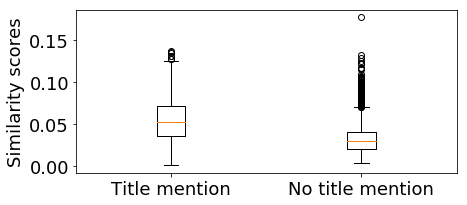

Number of items with title mention vs. without title mention: 3522 vs. 2565
Normality testing result:
	 With title-mention: p-value=0.00; without mention: p-value=0.00
Test difference between the two groups with Wilcoxon ranksum test (since sample is not normalily distributed)
	 Stats: 36.16, p-value=0.00


In [649]:
"""Analyse the relation between title mention and similarity to WP_VW page."""

# Get items whose titles contain "Volkswagen/VW/emission/scandal"
in_title = list(filter(lambda x: re.search(r'volkswagen|VW|emission|scandal', x['title'], re.I), D_VW))
out_title = list(filter(lambda x: re.search(r'volkswagen|VW|emission|scandal', x['title'], re.I) == None, D_VW))

# find corresponding similarity scores for with and without title mention.
sim_in_title = sims[[id_sims[d['id']] for d in in_title]]
sim_out_title = sims[[id_sims[d['id']] for d in out_title]]

# make a plot
fig = plt.figure(figsize=(15, 3))
ax = fig.add_subplot(121)
boxh = plt.boxplot([sim_in_title, sim_out_title])
ax.set_xticklabels(['Title mention', 'No title mention'])
ax.set_ylabel('Similarity scores')
plt.show()

print("Number of items with title mention vs. without title mention: %s vs. %s"%(len(in_title), len(out_title)))

# Normality test of the two groups of similarity scores.
stat1, p1 = normaltest(sim_in_title)
stat2, p2 = normaltest(sim_out_title)
print('Normality testing result:')
print('\t With title-mention: p-value=%.2f; without mention: p-value=%.2f'%(p1, p2))  

# Wilconxon test: whether two groups of similarity scores are different
print("Test difference between the two groups with Wilcoxon ranksum test (since sample is not normalily distributed)")
stats, p = ranksums(sim_in_title, sim_out_title)
print("\t Stats: %.2f, p-value=%.2f"%(stats, p))

### Heuristics derived:
Based on the above observations, I decide to apply the following heuristics to further filter the results:
* **Remove items without title mention.**
    - This will remove most of the irrelevant items (see manual inspection 1). 
    - Relevant items may also be removed, but will not be many. We can live with a smaller but more accurate sample.
* **Remove items with a similarity score to the WP_VW page lower than 0.011.**
    - This will remove most of the irrelvant items (see manual inspection 3).
    - Few irrelevant items may remain. For now we don't have a better way to handle it without labelled data.

In [657]:
"""Heuristic filtering news items with two rules:
 - Title should contain volkswagen/VW/emission/scandal, case in-sensitive;
 - Similarity score to WP_VW page should be above 0.05, inclusive.
"""
def heuristic_filtering(data):
    data_new = list(filter(lambda x: re.search(r'volkswagen|VW|emission|scandal', x['title'], re.I) and 
                sims[id_sims[x['id']]] > 0.011, data))
    return data_new

# Apply the heuristics.
D_VW_f = heuristic_filtering(D_VW)
D_VWS_f = heuristic_filtering(D_VWS)

## 2.3  Data set after heuristic filtering.
We observe the two versions of filtered datasets by inspecting the count of news about Volkswagen or Volkswagen emission scandal over time.

### Observations:
#### Both datasets have the following trend:
* More news items about VW as the event progress (initially around 09-03, and full outbreak after 09-18)
* News mentioning emission/scandal dominate after 09-18 following EPA's public announcement.

#### Comparing the datasets before and after heuristic filtering:
* The trend (i.e. the relative number of news over time) remains the same.
* We get relatively higher ratio of scandal related items w.r.t non-scandal related items after the event broke out. ==> This makes sense as after 09-18 we can expect most of the news on Volkswagen would be about the scandal.

In [651]:
"""Plot the count of news over dates."""
def plot_newscount_over_time(D_VW, D_VWS, title):
    C1 = dict(du.group_count(D_VW, field='date'))
    C2 = dict(du.group_count(D_VWS, field='date'))
    Xlabels = sorted(list(set(list(C1.keys()) + list(C2.keys()))))
    X = range(len(Xlabels))
    Y1 = [C1.get(x, 0) for x in Xlabels]
    Y2 = [C2.get(x, 0) for x in Xlabels]
    pu.bar_plot(np.array([X, X]), np.array([Y1, Y2]), barwidth=0.8, figsize=(25, 5), 
                xticks=X, xtick_labels=Xlabels, rotation='vertical',
                labels=["Volkswagen", "Volkswagen + emission/scandal"], title=title)
    plt.show()
    print('Total number of news mentionning "Volkswagen": %s'%len(D_VW))
    print('Total number of news mentionning "Volkswagen" and "emission/scandal": %s'%len(D_VWS))

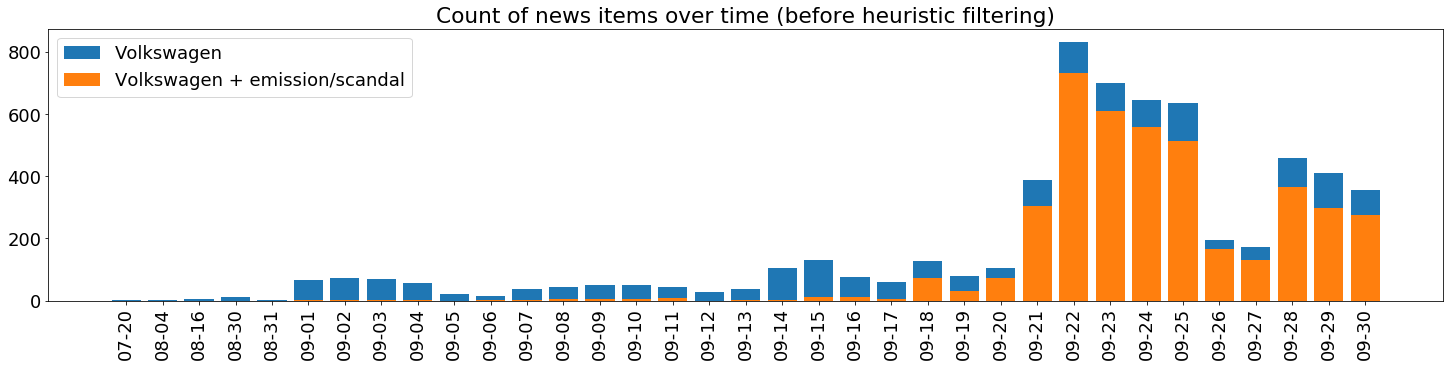

Total number of news mentionning "Volkswagen": 6087
Total number of news mentionning "Volkswagen" and "emission/scandal": 4186


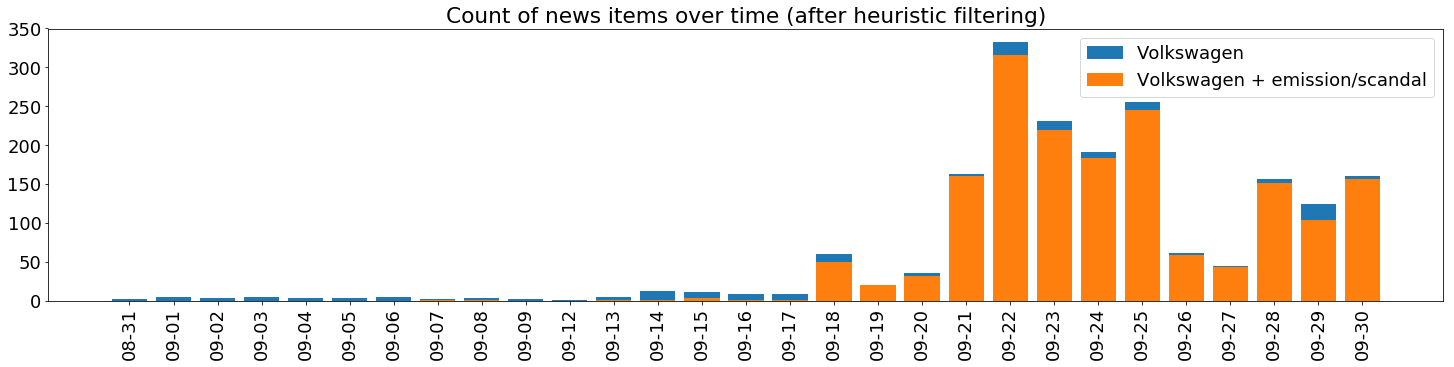

Total number of news mentionning "Volkswagen": 1911
Total number of news mentionning "Volkswagen" and "emission/scandal": 1750


In [652]:
"""Make plots"""
# Plot the initial dataset
plot_newscount_over_time(D_VW, D_VWS, "Count of news items over time (before heuristic filtering)")
# Re-plot the filtered dataset. 
plot_newscount_over_time(D_VW_f, D_VWS_f, "Count of news items over time (after heuristic filtering)")

## 2.4 Possible further analysis:
* Alternative representations, e.g. doc2vec, only using entities
* Consider temporal priors, as the closer to the major events, the likelihood that an article is about VW also increases.
* Classifier for filtering considering various features 
* However, without ground truth, variations of different representations/similarity measures are not comparable, so we do not go further here.

<a id="sentiment_analysis"></a>

# 3. Sentiment analysis on the news items

## 3.1 Quesitons to be answered:
* **Q1: How does sentiment towards VW change over time: before, during, and after the scandal roll out?**
* **Q2: What has been said about VW in the news?**
* **Q3: Which news channels have been most active in adding to the pos/neg sentiments? **

### Measuring sentiments 
* Using NLTK vader package
* Sentiments were measured at two levels:
    - Content
    - Title (As people may only look at titles)

In [653]:
"""Set up for sentiment analysis. """
vader = SentimentIntensityAnalyzer()

def sentiment(docs, field):
    sentiments = []
    for d in docs:
        score = vader.polarity_scores(d[field])
        sentiments.append((d['id'], score, d['date']))
    return sentiments   

# Compute sentiment scores over news content and titles
doc_scores = sentiment(D_VW_f, 'content')
title_scores = sentiment(D_VW_f, 'title')

## 3.2 Sentiment over time
### Method
For this task, we look at all the data about Volkswagen, i.e. not filtered by keywords "scandal/emission", as we want to see the overall sentiments towards the company. We plot the following stats:
- the count of **positive**, **negative**, and **neutral** items for each day
- the **ratio of positive vs. negative** items for each day

In [654]:
"""Make plot of identified sentiments over time. """
def sentiment_over_time(sent_scores, title=None):
    # Reduce the publishing time to just month-date
    sent_scores = [[t[0], t[1], t[2]] for t in sent_scores]
    
    # group by publishing date
    sent_scores.sort(key=lambda x: x[2])
    TS = []
    for k, g in it.groupby(sent_scores, lambda x: x[2]):
        X = [x[1] for x in g]
        TS.append((k, X))
    
    # Compute count of pos, neg, neu items each day
    Y_pos = np.array([len([x for x in scores[1] if x['compound']>0]) for scores in TS])
    Y_neg = -np.array([len([x for x in scores[1] if x['compound']<0]) for scores in TS])
    Y_neu = np.array([len([x for x in scores[1] if x['compound']==0]) for scores in TS])  
    bottoms = np.array([np.zeros(len(Y_pos)), np.zeros(len(Y_pos)), Y_neu])
    # Compute the pos vs. neg ratios each day (take a log for better visualisation)
    # Lap. smoothing: add 1 to avoid divided by 0.
    Y_ratio = np.log((Y_pos+1)/(-Y_neg+1))
    
    # X-axis: Dates as labels
    Xlabels = [x[0] for x in TS]
    X = range(len(Xlabels))
    
    ax, bars = pu.bar_plot(np.array([X, X, X]), np.array([Y_neu, Y_neg, Y_pos]), bottoms=bottoms, 
        barwidth=0.8, figsize=(25, 5), xticks=X, xtick_labels=Xlabels, rotation='vertical', ylim=(-400, 400), 
        ylabel="Count of items", title=title)
    
    # Right Y-axis: line plot for pos vs. neg ratio, axis label on right side
    ax2 = ax.twinx()
    line = pu.add_line(X, Y_ratio, ax2, ylim=(-3, 3), ylabel="pos/neg ratio")

    plt.legend(bars+[line],["neutral", "negative", "positive", "pos/neg ratio"], loc=3)
    plt.show()

### Observations - Q1: How does sentiment towards VW change before, during, and after the scandal broke out?
1. The change of sentiment follows the progress and checkpoints of the event:
    - **09-03**: Initial negative sentiment appears around when EPA initially brought up threats, but not obvious.
    - **09-18**: Sharp drop of pos/neg sentiment ratio, and increase of negative sentiments following the public announcement of EPA.
    - **09-22**: Negative sentiments reaches peak when VW admitted its violation, and continued for a few days
    - **09-28**: Another small peak of negative sentiments appeared as suspensions of staffs were announced.
2. **Similar trend** of sentiment change for both title and content, which makes sense. 
3. **Title vs. content**: more "positive" items are identified as "neutral" when measured on titles compared to content, while the number of negative items remain similar --> **not good for the company reputation as people may only read the headlines**.

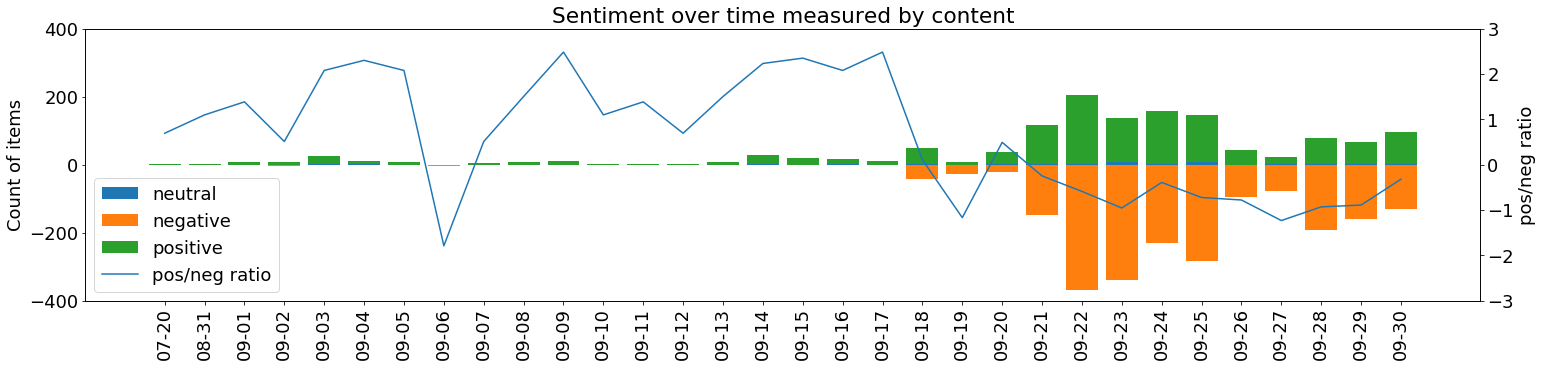

In [93]:
sentiment_over_time(doc_scores, title='Sentiment over time measured by content')

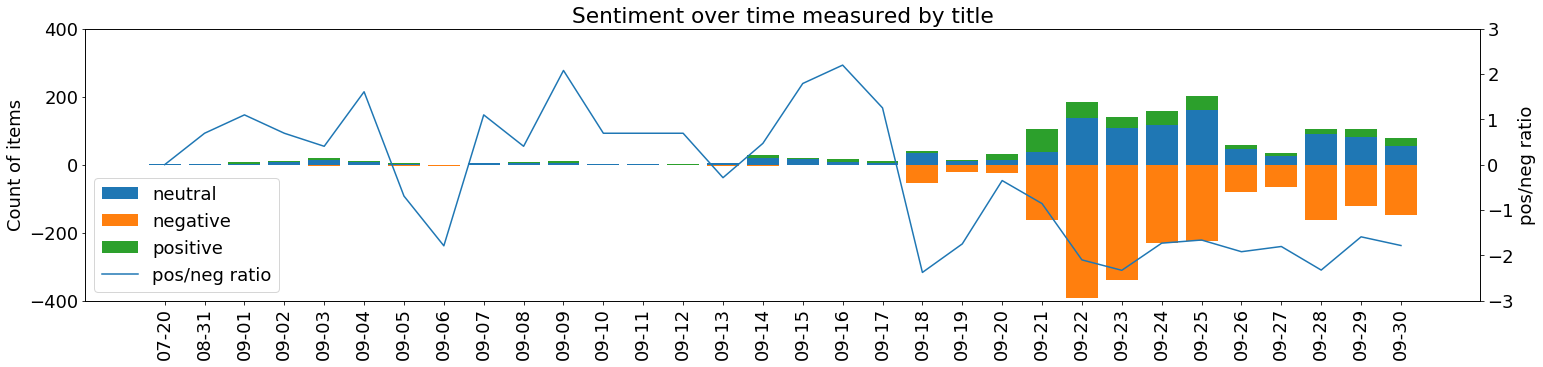

In [94]:
sentiment_over_time(title_scores, title='Sentiment over time measured by title')

## 3.3 What has been said about VW over time?
### Method
We look at what has been said about VW during this period by 
- Inspecting the most frequent terms mentioned in the titles of the news items
- Tfidf weights are used as the significance of a term

In [666]:
"""Extracting significant terms from news within a period"""
def topX_terms_over_time(docs, dates, topX):
    # Using TFIDF for term weighting
    c_vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 1), lowercase=False)
    vecs = c_vectorizer.fit_transform(docs)
    voc = c_vectorizer.get_feature_names()
    date_vecs.sort(key=lambda x: x[0])
    terms = []
    for k, g in it.groupby(date_vecs, lambda x: x[0]):
        # For each day, get all the items published on that day
        vec_idx = [d[1] for d in g]
        # Get the sum of tfidf scores for each term within this set
        sum_tfidf = np.sum(vecs[vec_idx, :], axis=0)
        # Sort terms by their total tfidf scores, get topX
        topx_idx = np.asarray(sum_tfidf.argsort()).squeeze()[-topX:][::-1]
        # Also get the term weights
        w = np.asarray(sum_tfidf[0, topx_idx]).squeeze()
        terms.append((k, list(zip([voc[i] for i in topx_idx], w))))
    return terms

### Visualize top terms
- We plot the top 5 terms that appear in the headlines for each day
- As titles are short, we use unigrams only
- Word size reflects their TFIDF weights. To also reflect the total number of mentions of these terms, i.e. the number of items published on a day about VW, we do not normalize the TFIDF scores over the number of items. 

In [669]:
"""Make a plot of the top X terms"""
def plot_topX_terms(T):
    cols = 6
    rows = math.floor(len(T)/cols) + int(len(T)%cols>0)
    for i in range(rows):
        fig = plt.figure(figsize=(25, 5))
        for j in range(cols):
            ax = fig.add_subplot(1, cols, j+1)
            ax.axis('off')
            ax.set_ylim((-1, 0))
            canvas = ax.figure.canvas
            idx = i * cols + j
            if idx < len(T):
                date, terms = T[idx]
            x, y = (0, 0)
            # Write date
            text = ax.text(x, y, date, size=20, weight="bold")
            text.draw(canvas.get_renderer())
            ex = text.get_window_extent()
            trans = matplotlib.transforms.offset_copy(text._transform, y=y-ex.height-15, units='dots')
            # write terms
            for t, w in terms:
                # For better visibility, normalize the weights.
                text = ax.text(x, y, t, transform=trans, size=np.log(w+5)*10)
                text.draw(canvas.get_renderer())
                ex = text.get_window_extent()
                trans = matplotlib.transforms.offset_copy(text._transform, y=y-ex.height-3, units='dots')   
                
    plt.show()   

### Observation - Q2: What has been said about Volkswagen?
From the most significant terms, we can clearly see that the key events on the timeline:
- Before 09-18, not much was said about VW.
- on 09-18/19, EPA was mentioned, as the news on that day is about EPA made the public announcement
- on 09-20, VW made initial public response, where "Sorry" (apology) is the keyword
- on 09-22, VW admitted their fault, and words like "Volkswagen", "scandal", "emission", officially appear, with many mentions in the news around those days
- on 09-23, VW CEO resigned, where word "CEO" was significant for that day and the following day
- on 09-28, another little peak about the scandal appeared as VW internal investigation started

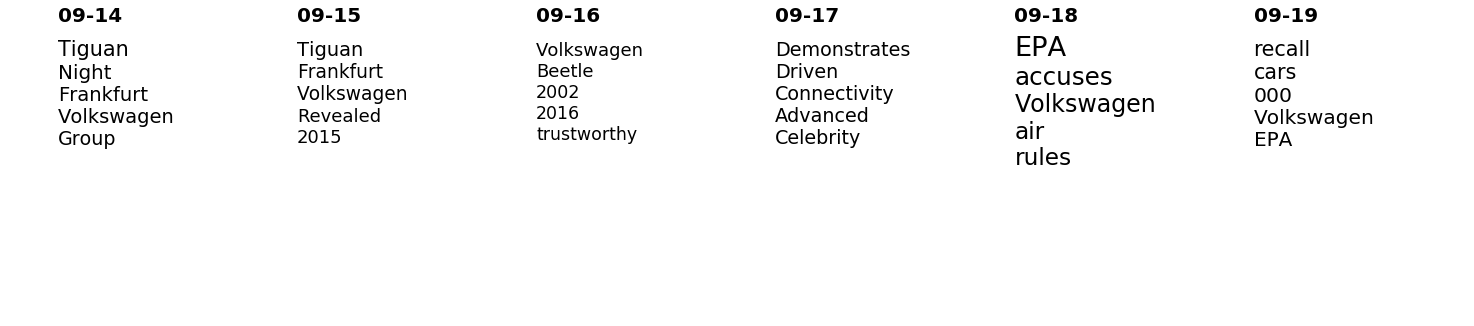

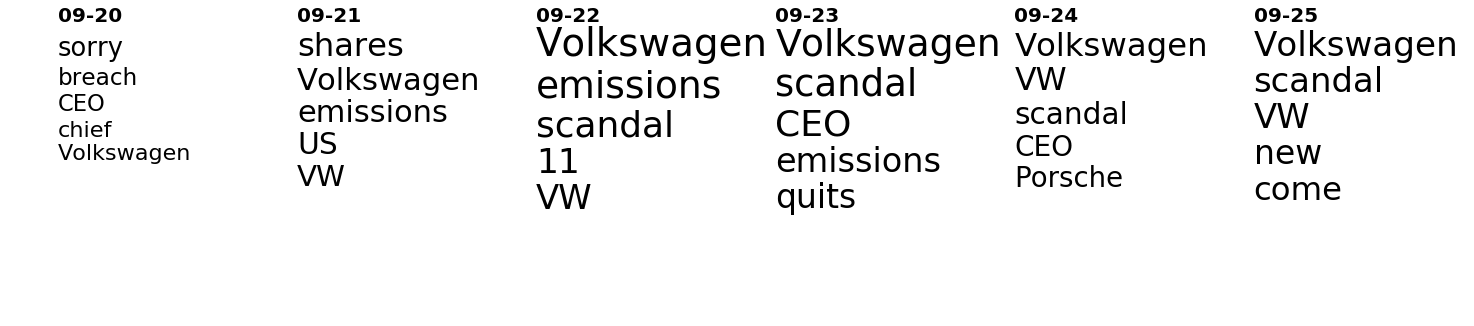

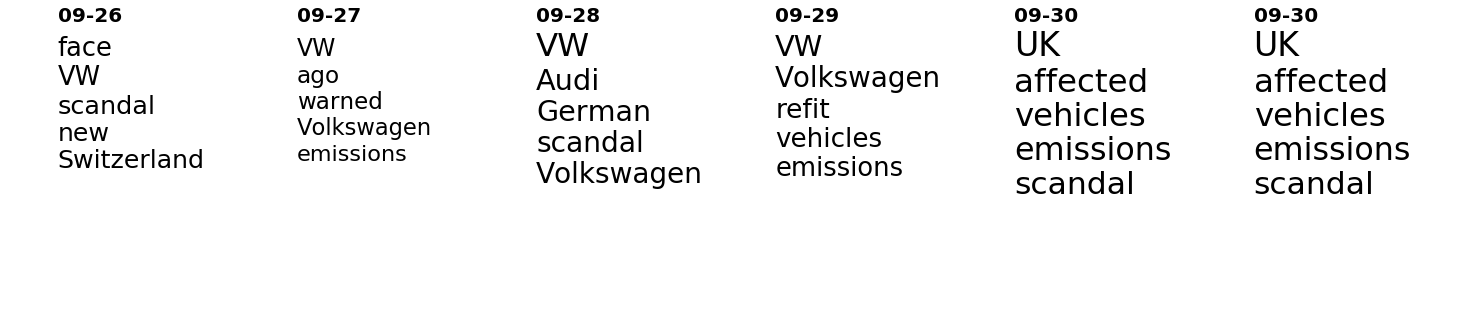

In [671]:
topX = 5
# Prepare data for plot
titles = [d['title'] for d in D_VW_f]
date_vecs = [(D_VW_f[i]['date'], i) for i in range(len(D_VW_f))]
terms = topX_terms_over_time(titles, dates, topX)
plot_topX_terms(terms[15:])

## 3.4 Sentiment impact by sources
### Method
* We first look at the general news source activities in terms of:
    - The timeline of news sources joining the reporting activities
    - How active are news sources reporting the scandal?
* Then we look at the impact of the most active news sources in shaping the sentiments
    - Contribution of individual source to sentiments as the proportion of its pos/neg reports to the accumulative pos/neg sentiments per day 
    
### Data
* We look at the **scandal related subset** of the data.
* We use **content level** sentiment scores for analysis

In [232]:
"""Prepare data for analysing source activities"""
def count_days_by_source(X):
    """Group the data by source, and count the number of items generated by each source"""
    X.sort(key=lambda x: x["source"])
    count = []
    for k, g in it.groupby(X, lambda x: x['source']):
        count.append((k, len(set([y['date'] for y in g]))))
    return count
    
def count_source_by_day(X):
    """Group the data by day, within each day, by source"""
    X.sort(key=lambda x: x['date'])
    count = []
    for k, g in it.groupby(X, lambda x: x['date']):
        count.append((k, len(set([gg['source'] for gg in g]))))
    return count
    
# Get the counts    
X = [{'source': d['source'], 'date': d['date']} for d in D_VWS_f]

# Group the data by source, and count the number of items generated by each source
item_count_by_source = du.group_count(X, field="source")

day_count_by_source = count_days_by_source(X)  
source_by_day_count = count_source_by_day(X)

### Observation - Q2 (a) News sources activities over time
* Scandal related news were first reported by very few news sources. After 09-18, more sources participated in reporting.
* Most sources only reported it once or twice. A small number of sources reported multiple times.
* A small number of sources reported for a couple of days.

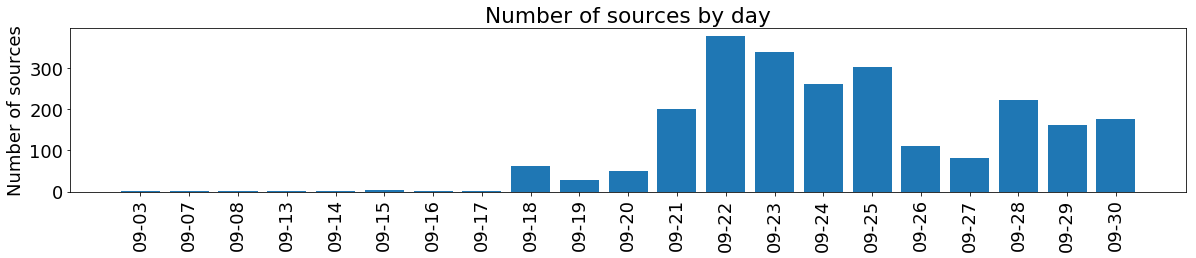

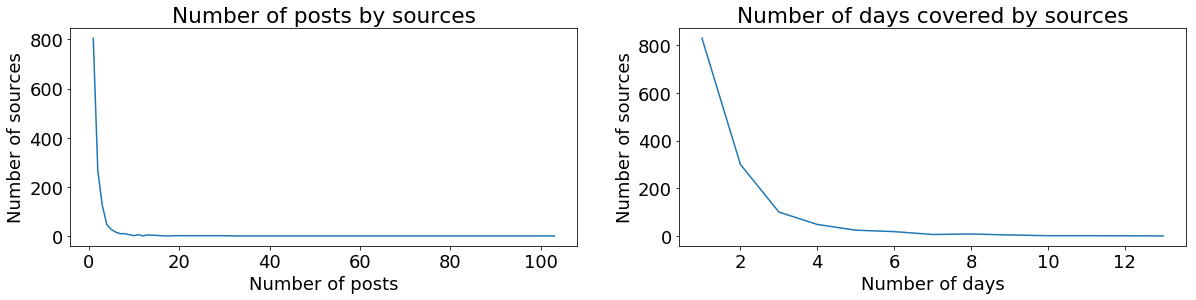

In [96]:
"""Plot source activities"""
# Number of sources reporting by day
X = range(len(source_by_day_count))
Xlabels = [x[0] for x in source_by_day_count]
Y = np.array([x[1] for x in source_by_day_count])
pu.bar_plot(np.array(X).reshape(1, len(X)), Y.reshape(1, len(X)), barwidth=0.8, figsize=(20, 3), 
            ylabel="Number of sources", xticks=X, xtick_labels=Xlabels, rotation='vertical', 
            title="Number of sources by day")

# Number of items reported by individual sources.
fig1 = plt.figure(figsize=(20, 4))
ax1 = fig1.add_subplot(121)
X = [x[1] for x in item_count_by_source]
Y = [(k, len(list(g))) for k, g in it.groupby(sorted(X))]
plt.plot([x[0] for x in Y], [y[1] for y in Y])
ax1.set_xlabel("Number of posts")
ax1.set_ylabel("Number of sources")
ax1.set_title("Number of posts by sources")

# Number of days covered by individual sources.
ax2 = fig1.add_subplot(122)
X = [x[1] for x in day_count_by_source]
Y = [(k, len(list(g))) for k, g in it.groupby(sorted(X))]
plt.plot([x[0] for x in Y], [y[1] for y in Y])
ax2.set_xlabel("Number of days")
ax2.set_ylabel("Number of sources")
ax2.set_title("Number of days covered by sources")
plt.show()

### Obervstion - Q2 (b) Impact of the most active sources in shaping sentiment.
* The top 5 most active news sources are:
    - MyInforms
    - Reuters UK
    - Reuters
    - Yahoo! Finance UK
    - 4 Traders
* The top 5 sources all contributed to the negative sentiments of VW. 
    - Together they contribute to about 10% of the negative sentiments.
    - MyInforms, Reuters UK, Reuters, and Yahoo! Finance UK also has been reporting for many days.
* Some of the top 10 most frequent sources have mixed sentiments
    - e.g. Yahoo! India and CNBC

In [97]:
"""Data preperation"""
#Get docids in the scandal subset for filtering the sentiment scores
docid_sc = dict([(d['id'], d) for d in D_VWS_f])
sent_scores = filter(lambda x: x[0] in docid_sc, title_scores)
# Combine sentiment scores with news item data
sent_scores = [{'id': s[0], 'score': s[1]['compound'], 
                'date': s[2],
                'source': docid_sc[s[0]]['source']
                } for s in sent_scores]

In [98]:
def contribution_by_day(sentiment_scores):
    sentiment_scores.sort(key=lambda x: x['date'])
    contr = []
    for k, g in it.groupby(sentiment_scores, lambda x: x['date']):
        g = list(g)
        # contribution as the accumulative sentiment score of a source
        # If the source gives mixed (pos and neg) sentiments, then they cancel out.
        g.sort(key=lambda x: x['source'])
        day_contr = {}
        for kk, gg in it.groupby(g, lambda x: x['source']):
            c = [x['score'] for x in gg]
            pos = len([score for score in c if score > 0])
            neg = len([score for score in c if score < 0])
            day_contr[kk] = pos-neg
        # also get the total contribution from everyone
        day_contr['total_pos'] = sum([day_contr[source] for source in day_contr if day_contr[source]>0])
        day_contr['total_neg'] = sum([day_contr[source] for source in day_contr if day_contr[source]<0])
        day_contr['total_neu'] = sum([day_contr[source] for source in day_contr if day_contr[source]==0])
        contr.append((k, day_contr))
    return dict(contr)

contribution = contribution_by_day(sent_scores)

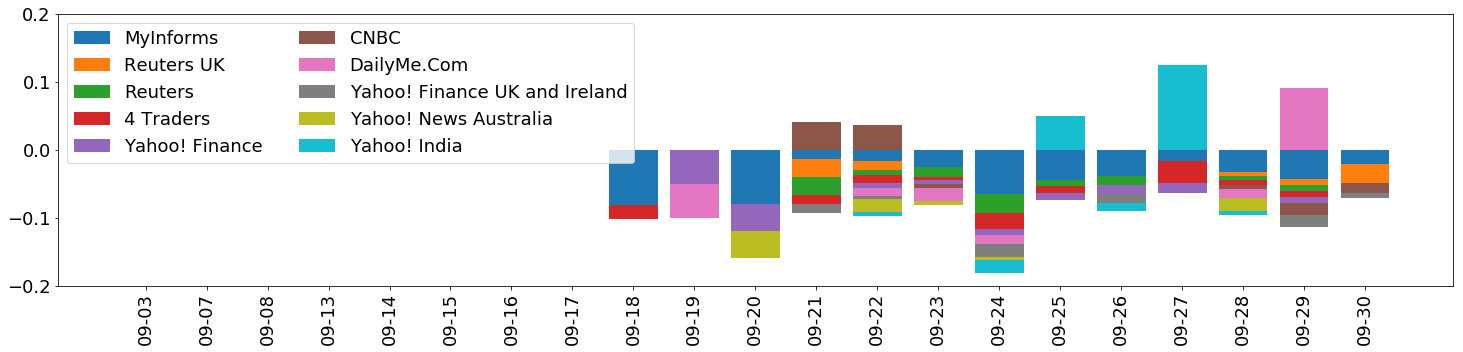

In [99]:
"""Plot the top 5 frequent sources' contributions by day"""
def contribution_topX(contribution, topX):
    # Compute the relative contribution of the topX sources to neg/pos sentiments
    SCD = []
    for date in contribution:
        C = contribution[date]
        SC = {}
        tot_pos = C.get('total_pos')
        tot_neg = C.get('total_neg')
        source_pos = 0
        source_neg = 0
        for source, count in topX:
            source_score = C.get(source, 0)
            if source_score > 0:
                SC[source] = source_score/tot_pos
                source_pos += source_score
            elif source_score < 0:
                SC[source] = -source_score/tot_neg
                source_neg += source_score
            else:
                SC[source] = 0
        SCD.append((date, SC))
    return SCD

# Get top 5 frequent sources.
topX = sorted(item_count_by_source, key=lambda x: x[1], reverse=True)[0:10]
# Compute their relative contributions
SC = contribution_topX(contribution, topX)

fig, ax = plt.subplots(figsize=(25, 5))
X = [x[0].replace('2015-', '') for x in SC]
neg_bottom = np.zeros(len(X))
pos_bottom = np.zeros(len(X))
labels = []
for source, count in topX:
    Y = [x[1][source] for x in SC]
    bot = [pos_bottom[i] if Y[i] > 0 else neg_bottom[i] for i in range(len(Y))]
    ax.bar(X, Y, width=0.8, bottom=bot)
    neg_bottom = [neg_bottom[i]+Y[i] if Y[i] < 0 else neg_bottom[i] for i in range(len(Y))]
    pos_bottom = [pos_bottom[i]+Y[i] if Y[i] > 0 else pos_bottom[i] for i in range(len(Y))]
    labels.append(source)
ax.legend(labels, ncol=2, loc=2)
ax.set_xticklabels(X, rotation='vertical')
ax.set_ylim(-.2, 0.2)
plt.show()

## 3.5 Possible further analysis
News sources have their circulations, which is a major indicator of their impact. Such information, if avilable, can be used to predict the impact of an article. Some circulation data is available in Wikipedia (infobox), however, the overlap between the WP data and the news sources in this data set is rather low. Therefore I did not look further.

<a id="limitations"></a>
# 4. Limitations
The reliability of the result of this analysis depends on:
* The accuracy of the filtering results
* The accuracy of the sentiment analysis results, including
    - The choice of text preprocessing
    - The choice of the field to be analysed


## Appendix: Code for manual inspection

In [63]:
# Insepct samples of news items considering title mention and similarity scores.
out_ = [(sims[id_sims[x['id']]], x) for x in out_title]
in_ = [(sims[id_sims[x['id']]], x) for x in in_title]

def get_sample(min_score, max_score, count):
    items = list(filter(lambda x: min_score <= x[0]<=max_score, in_))
    random.shuffle(items)
    return items[0:count]

"""
# Uncomment to inspect top 50 items without title mention, sorted by similarity to WP_VW article
#
out_.sort(key=lambda x: x[0], reverse=True)
for x in out_[0:50]:
    print('title:', x[1]['title'], x[1]['published'], x[1]['source'], x[0])
    print(re.sub('\s+', ' ', x[1]['content'][0:2000]))
    print('======')
    print()
"""
"""   
# Uncomment to inspect top 50 dissimilar items with title mention
# sorted by similarity to WP_VW articles
#
in_.sort(key=lambda x: x[0])
# A random sample of 50 items from lowest 5% of the items
count = int(len(in_)*5/100)
sample = in_[0:count]
for x in sample[50:100]:
    print('title:', x[1]['title'], x[1]['published'], x[1]['source'], x[0])
    print(re.sub('\s+', ' ', x[1]['content'])[0:2000])
    print('======')
    print()
"""
"""
# Uncomment to inspect random samples of items with title mention 
# in different ranges of similarity scores to the WP_VW page.
for interval in [(0, 0.05), (0.05, 0.1), (0.1, 0.2), (0.2, 0.3)]:
    sample = get_sample(interval[0], interval[1], 10)
    for x in sample:
        print('title:', x[1]['title'], x[1]['published'], x[1]['source'], x[0])
        print(re.sub('\s+', ' ', x[1]['content'])[0:2000])
        print('======')
        print()
"""
print()